
# StreamReader Advanced Usages

**Author**: [Moto Hira](moto@meta.com)_

This tutorial is the continuation of
[StreamReader Basic Usages](./streamreader_basic_tutorial.html)_.

This shows how to use :py:class:`~torchaudio.io.StreamReader` for

- Device inputs, such as microphone, webcam and screen recording
- Generating synthetic audio / video
- Applying preprocessing with custom filter expressions


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import IPython
import matplotlib.pyplot as plt
from torchaudio.io import StreamReader

base_url = "https://download.pytorch.org/torchaudio/tutorial-assets"
AUDIO_URL = f"{base_url}/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
VIDEO_URL = f"{base_url}/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4.mp4"

2.1.0+cu118
2.1.0+cu118


## Audio / Video device input

.. seealso::

   - [Accelerated Video Decoding with NVDEC](../hw_acceleration_tutorial.html)_.
   - [Online ASR with Emformer RNN-T](./online_asr_tutorial.html)_.
   - [Device ASR with Emformer RNN-T](./device_asr.html)_.

Given that the system has proper media devices and libavdevice is
configured to use the devices, the streaming API can
pull media streams from these devices.

To do this, we pass additional parameters ``format`` and ``option``
to the constructor. ``format`` specifies the device component and
``option`` dictionary is specific to the specified component.

The exact arguments to be passed depend on the system configuration.
Please refer to https://ffmpeg.org/ffmpeg-devices.html for the detail.

The following example illustrates how one can do this on MacBook Pro.

First, we need to check the available devices.

.. code::

   $ ffmpeg -f avfoundation -list_devices true -i ""
   [AVFoundation indev @ 0x143f04e50] AVFoundation video devices:
   [AVFoundation indev @ 0x143f04e50] [0] FaceTime HD Camera
   [AVFoundation indev @ 0x143f04e50] [1] Capture screen 0
   [AVFoundation indev @ 0x143f04e50] AVFoundation audio devices:
   [AVFoundation indev @ 0x143f04e50] [0] MacBook Pro Microphone

We use `FaceTime HD Camera` as video device (index 0) and
`MacBook Pro Microphone` as audio device (index 0).

If we do not pass any ``option``, the device uses its default
configuration. The decoder might not support the configuration.

.. code::

   >>> StreamReader(
   ...     src="0:0",  # The first 0 means `FaceTime HD Camera`, and
   ...                 # the second 0 indicates `MacBook Pro Microphone`.
   ...     format="avfoundation",
   ... )
   [avfoundation @ 0x125d4fe00] Selected framerate (29.970030) is not supported by the device.
   [avfoundation @ 0x125d4fe00] Supported modes:
   [avfoundation @ 0x125d4fe00]   1280x720@[1.000000 30.000000]fps
   [avfoundation @ 0x125d4fe00]   640x480@[1.000000 30.000000]fps
   Traceback (most recent call last):
     File "<stdin>", line 1, in <module>
     ...
   RuntimeError: Failed to open the input: 0:0

By providing ``option``, we can change the format that the device
streams to a format supported by decoder.

.. code::

   >>> streamer = StreamReader(
   ...     src="0:0",
   ...     format="avfoundation",
   ...     option={"framerate": "30", "pixel_format": "bgr0"},
   ... )
   >>> for i in range(streamer.num_src_streams):
   ...     print(streamer.get_src_stream_info(i))
   SourceVideoStream(media_type='video', codec='rawvideo', codec_long_name='raw video', format='bgr0', bit_rate=0, width=640, height=480, frame_rate=30.0)
   SourceAudioStream(media_type='audio', codec='pcm_f32le', codec_long_name='PCM 32-bit floating point little-endian', format='flt', bit_rate=3072000, sample_rate=48000.0, num_channels=2)





## Synthetic source streams

As a part of device integration, ffmpeg provides a "virtual device"
interface. This interface provides synthetic audio / video data
generation using libavfilter.

To use this, we set ``format=lavfi`` and provide a filter description
to ``src``.

The detail of filter description can be found at
https://ffmpeg.org/ffmpeg-filters.html




### Audio Examples




#### Sine wave
https://ffmpeg.org/ffmpeg-filters.html#sine

.. code::

   StreamReader(src="sine=sample_rate=8000:frequency=360", format="lavfi")

.. raw:: html

   <audio controls>
       <source src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/sine.wav">
   </audio>
   <img
    src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/sine.png"
    class="sphx-glr-single-img" style="width:80%">




#### Signal with arbitral expression

https://ffmpeg.org/ffmpeg-filters.html#aevalsrc

.. code::

   # 5 Hz binaural beats on a 360 Hz carrier
   StreamReader(
       src=(
           'aevalsrc='
           'sample_rate=8000:'
           'exprs=0.1*sin(2*PI*(360-5/2)*t)|0.1*sin(2*PI*(360+5/2)*t)'
       ),
       format='lavfi',
    )

.. raw:: html

   <audio controls>
       <source src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/aevalsrc.wav">
   </audio>
   <img
    src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/aevalsrc.png"
    class="sphx-glr-single-img" style="width:80%">




#### Noise
https://ffmpeg.org/ffmpeg-filters.html#anoisesrc

.. code::

   StreamReader(src="anoisesrc=color=pink:sample_rate=8000:amplitude=0.5", format="lavfi")

.. raw:: html

   <audio controls>
       <source src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/anoisesrc.wav">
   </audio>
   <img
    src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/anoisesrc.png"
    class="sphx-glr-single-img" style="width:80%">




### Video Examples




#### Cellular automaton
https://ffmpeg.org/ffmpeg-filters.html#cellauto

.. code::

   StreamReader(src=f"cellauto", format="lavfi")

.. raw:: html

   <video controls autoplay loop muted>
       <source src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/cellauto.mp4">
   </video>




#### Mandelbrot
https://ffmpeg.org/ffmpeg-filters.html#cellauto

.. code::

   StreamReader(src=f"mandelbrot", format="lavfi")

.. raw:: html

   <video controls autoplay loop muted>
       <source src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/mandelbrot.mp4">
   </video>




#### MPlayer Test patterns
https://ffmpeg.org/ffmpeg-filters.html#mptestsrc

.. code::

   StreamReader(src=f"mptestsrc", format="lavfi")

.. raw:: html

   <video controls autoplay loop muted width=192 height=192>
       <source src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/mptestsrc.mp4">
   </video>




#### John Conway's life game
https://ffmpeg.org/ffmpeg-filters.html#life

.. code::

   StreamReader(src=f"life", format="lavfi")

.. raw:: html

   <video controls autoplay loop muted>
       <source src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/life.mp4">
   </video>




#### Sierpinski carpet/triangle fractal
https://ffmpeg.org/ffmpeg-filters.html#sierpinski

.. code::

   StreamReader(src=f"sierpinski", format="lavfi")

.. raw:: html

   <video controls autoplay loop muted>
       <source src="https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/sierpinski.mp4">
   </video>




## Custom filters

When defining an output stream, you can use
:py:meth:`~torchaudio.io.StreamReader.add_audio_stream` and
:py:meth:`~torchaudio.io.StreamReader.add_video_stream` methods.

These methods take ``filter_desc`` argument, which is a string
formatted according to ffmpeg's
[filter expression](https://ffmpeg.org/ffmpeg-filters.html).

The difference between ``add_basic_(audio|video)_stream`` and
``add_(audio|video)_stream`` is that ``add_basic_(audio|video)_stream``
constructs the filter expression and passes it to the same underlying
implementation. Everything ``add_basic_(audio|video)_stream`` can be
achieved with ``add_(audio|video)_stream``.

<div class="alert alert-info"><h4>Note</h4><p>- When applying custom filters, the client code must convert
     the audio/video stream to one of the formats that torchaudio
     can convert to tensor format.
     This can be achieved, for example, by applying
     ``format=pix_fmts=rgb24`` to video stream and
     ``aformat=sample_fmts=fltp`` to audio stream.
   - Each output stream has separate filter graph. Therefore, it is
     not possible to use different input/output streams for a
     filter expression. However, it is possible to split one input
     stream into multiple of them, and merge them later.</p></div>




### Audio Examples





In [2]:
# fmt: off
descs = [
    # No filtering
    "anull",
    # Apply a highpass filter then a lowpass filter
    "highpass=f=200,lowpass=f=1000",
    # Manipulate spectrogram
    (
        "afftfilt="
        "real='hypot(re,im)*sin(0)':"
        "imag='hypot(re,im)*cos(0)':"
        "win_size=512:"
        "overlap=0.75"
    ),
    # Manipulate spectrogram
    (
        "afftfilt="
        "real='hypot(re,im)*cos((random(0)*2-1)*2*3.14)':"
        "imag='hypot(re,im)*sin((random(1)*2-1)*2*3.14)':"
        "win_size=128:"
        "overlap=0.8"
    ),
]
# fmt: on

In [3]:
sample_rate = 8000

streamer = StreamReader(AUDIO_URL)
for desc in descs:
    streamer.add_audio_stream(
        frames_per_chunk=40000,
        filter_desc=f"aresample={sample_rate},{desc},aformat=sample_fmts=fltp",
    )

chunks = next(streamer.stream())


def _display(i):
    print("filter_desc:", streamer.get_out_stream_info(i).filter_description)
    fig, axs = plt.subplots(2, 1)
    waveform = chunks[i][:, 0]
    axs[0].plot(waveform)
    axs[0].grid(True)
    axs[0].set_ylim([-1, 1])
    plt.setp(axs[0].get_xticklabels(), visible=False)
    axs[1].specgram(waveform, Fs=sample_rate)
    fig.tight_layout()
    return IPython.display.Audio(chunks[i].T, rate=sample_rate)

#### Original




filter_desc: aresample=8000,anull,aformat=sample_fmts=fltp


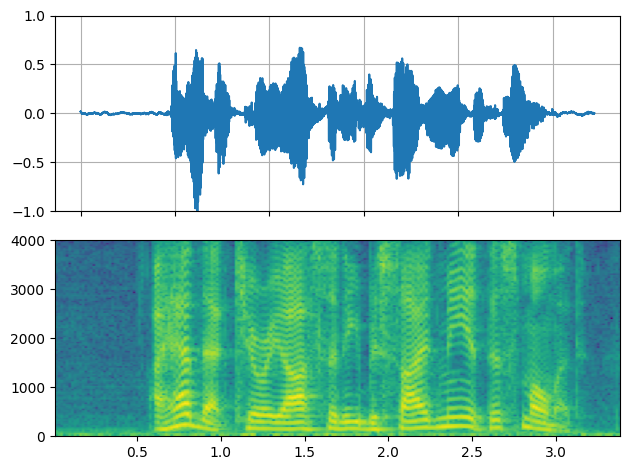

In [4]:
_display(0)

#### Highpass / lowpass filter




filter_desc: aresample=8000,highpass=f=200,lowpass=f=1000,aformat=sample_fmts=fltp


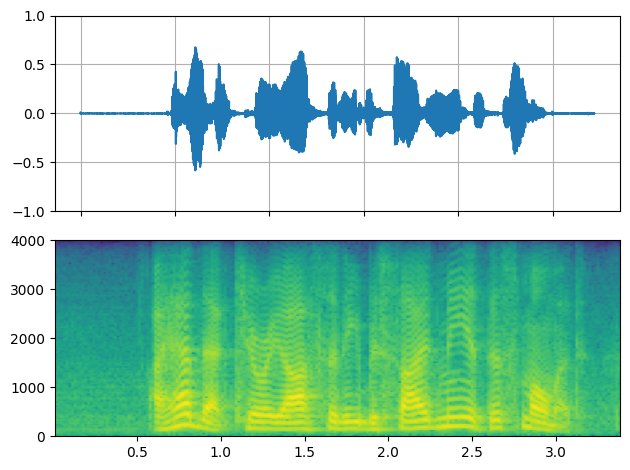

In [5]:
_display(1)

#### FFT filter - Robot 🤖




filter_desc: aresample=8000,afftfilt=real='hypot(re,im)*sin(0)':imag='hypot(re,im)*cos(0)':win_size=512:overlap=0.75,aformat=sample_fmts=fltp


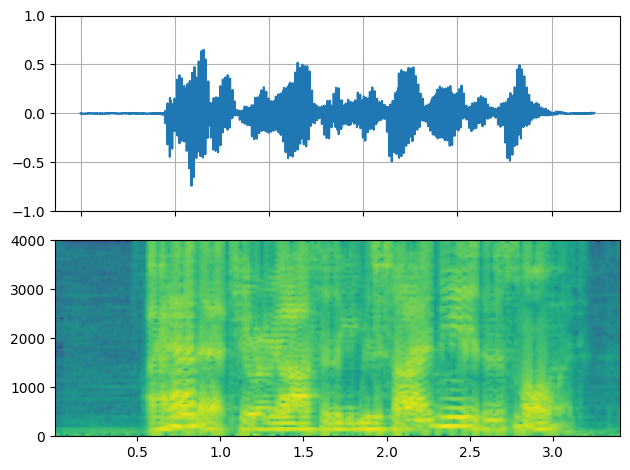

In [8]:
_display(2)

#### FFT filter - Whisper




filter_desc: aresample=8000,afftfilt=real='hypot(re,im)*cos((random(0)*2-1)*2*3.14)':imag='hypot(re,im)*sin((random(1)*2-1)*2*3.14)':win_size=128:overlap=0.8,aformat=sample_fmts=fltp


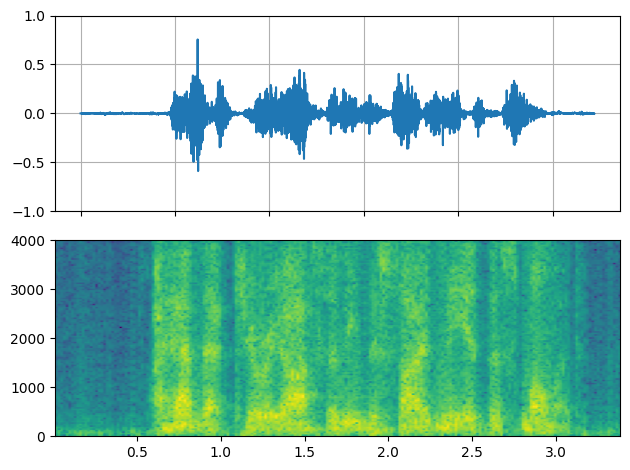

In [7]:
_display(3)

### Video Examples




In [9]:
# fmt: off
descs = [
    # No effect
    "null",
    # Split the input stream and apply horizontal flip to the right half.
    (
        "split [main][tmp];"
        "[tmp] crop=iw/2:ih:0:0, hflip [flip];"
        "[main][flip] overlay=W/2:0"
    ),
    # Edge detection
    "edgedetect=mode=canny",
    # Rotate image by randomly and fill the background with brown
    "rotate=angle=-random(1)*PI:fillcolor=brown",
    # Manipulate pixel values based on the coordinate
    "geq=r='X/W*r(X,Y)':g='(1-X/W)*g(X,Y)':b='(H-Y)/H*b(X,Y)'"
]
# fmt: on

In [10]:
streamer = StreamReader(VIDEO_URL)
for desc in descs:
    streamer.add_video_stream(
        frames_per_chunk=30,
        filter_desc=f"fps=10,{desc},format=pix_fmts=rgb24",
    )

streamer.seek(12)

chunks = next(streamer.stream())


def _display(i):
    print("filter_desc:", streamer.get_out_stream_info(i).filter_description)
    _, axs = plt.subplots(1, 3, figsize=(8, 1.9))
    chunk = chunks[i]
    for j in range(3):
        axs[j].imshow(chunk[10 * j + 1].permute(1, 2, 0))
        axs[j].set_axis_off()
    plt.tight_layout()

#### Original



filter_desc: fps=10,null,format=pix_fmts=rgb24


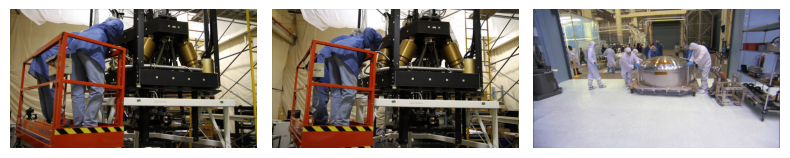

In [11]:
_display(0)

#### Mirror



filter_desc: fps=10,split [main][tmp];[tmp] crop=iw/2:ih:0:0, hflip [flip];[main][flip] overlay=W/2:0,format=pix_fmts=rgb24


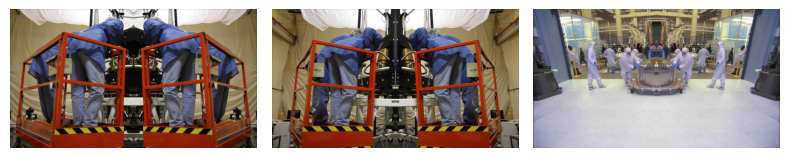

In [12]:
_display(1)

#### Edge detection



filter_desc: fps=10,edgedetect=mode=canny,format=pix_fmts=rgb24


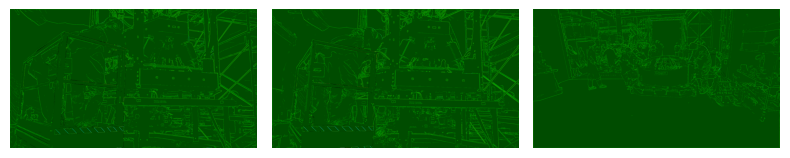

In [13]:
_display(2)

#### Random rotation



filter_desc: fps=10,rotate=angle=-random(1)*PI:fillcolor=brown,format=pix_fmts=rgb24


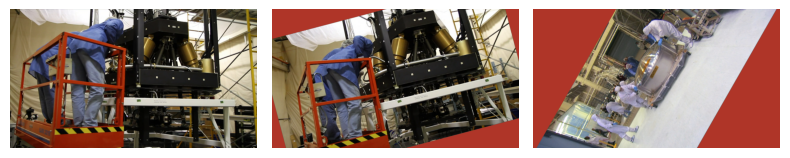

In [14]:
_display(3)

#### Pixel manipulation



filter_desc: fps=10,geq=r='X/W*r(X,Y)':g='(1-X/W)*g(X,Y)':b='(H-Y)/H*b(X,Y)',format=pix_fmts=rgb24


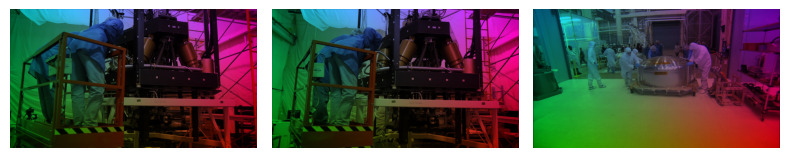

In [15]:
_display(4)

Tag: :obj:`torchaudio.io`

